In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [2]:
from azureml.core.runconfig import RunConfiguration
from azureml.core import Workspace, Experiment, Run, ScriptRunConfig, Datastore, Dataset
from azureml.core.model import Model
import json
import os
from azureml.core.authentication import AzureCliAuthentication
from sklearn.externals import joblib

In [3]:
#Service Principal Authentication

from azureml.core.authentication import ServicePrincipalAuthentication
import os

base_dir='./../configuration'
config_json = os.path.join(base_dir, "config.json")
with open(config_json, "r") as f:
    config = json.load(f)

workspace_name = config["workspace_name"]
resource_group = config["resource_group"]
subscription_id = config["subscription_id"]
location = config["location"]
    
auth = ServicePrincipalAuthentication(
    tenant_id=config["tenant_id"],
    service_principal_id=config["service_principal_id"],
    service_principal_password=config["service_principal_password"],
)

ws = Workspace.get(
        name=workspace_name,
        subscription_id=subscription_id,
        resource_group=resource_group,        
        auth=auth
    )

print('Workspace name: ' + ws.name, 'Azure region: ' + ws.location, 'Subscription id: ' + ws.subscription_id,'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: ShivaMLservice
Azure region: westus2
Subscription id: 46668180-b0ad-4a49-bed9-88f16f315dce
Resource group: MLGroup


In [17]:
dataset = Dataset.get_by_name(workspace=ws, name='transaction_ts2013')
df = dataset.to_pandas_dataframe()
df.tail()

,TransactionDate,PaidAmount
149,2013-12-27,192.231733
150,2013-12-28,168.955579
151,2013-12-29,181.225667
152,2013-12-30,886.224597
153,2013-12-31,1451.365274


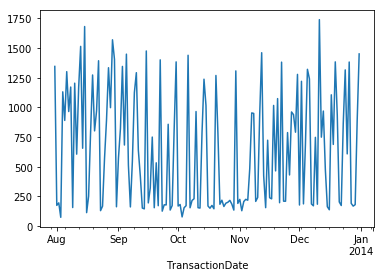

In [18]:
df.set_index('TransactionDate',inplace=True)
df.columns = ['PaidAmount']
series = pd.Series(df['PaidAmount'])
series.plot()
plt.show()

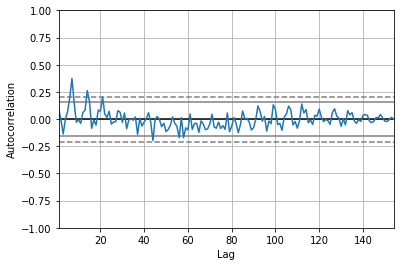

In [6]:
autocorrelation_plot(series)

#suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.
# there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

In [19]:
#mean and variance test to check if the series is stationary. Huge difference in mean and variance values imply it is not stationary
def mean_and_variance(X):
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
mean_and_variance(series.values)

mean1=687.552081, mean2=589.517712
variance1=250436.569758, variance2=211093.208980


In [20]:
def fuller_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
        
fuller_test(series.values)

# p-value is not less than 0.05, hence not stationary

ADF Statistic: -2.023258
p-value: 0.276469
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.577


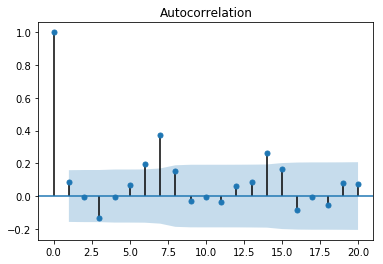

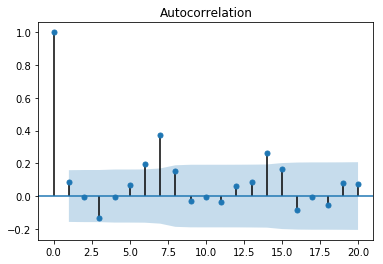

In [21]:
plot_acf(series, lags=20)

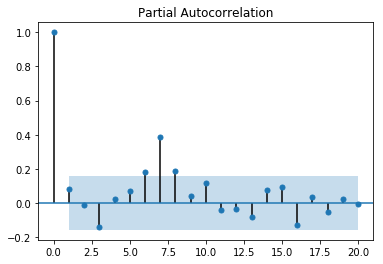

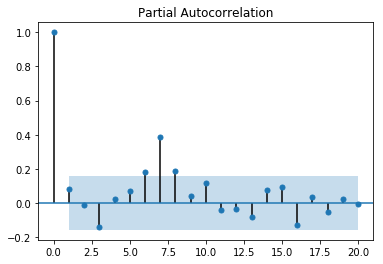

In [22]:
plot_pacf(series, lags=20)

In [ ]:
!pip install pmdarima

In [32]:
#since there is no auto.arima function in Python, we can grid search arima model parameters

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.9)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [33]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [34]:
# grid-search and evaluate parameters
import warnings
warnings.filterwarnings("ignore")

p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=248724.445
ARIMA(0, 0, 1) MSE=244928.616
ARIMA(0, 0, 2) MSE=248023.667
ARIMA(0, 0, 3) MSE=229022.686
ARIMA(0, 0, 4) MSE=234790.302
ARIMA(0, 1, 0) MSE=400324.254
ARIMA(0, 1, 1) MSE=259477.368
ARIMA(0, 1, 2) MSE=260708.961
ARIMA(1, 0, 0) MSE=245406.611
ARIMA(1, 0, 1) MSE=245822.570
ARIMA(1, 1, 0) MSE=382495.705
ARIMA(2, 0, 0) MSE=246984.818
ARIMA(2, 0, 1) MSE=241577.468
ARIMA(2, 1, 0) MSE=397183.054
ARIMA(3, 0, 0) MSE=222065.308
ARIMA(3, 0, 1) MSE=224342.067
ARIMA(3, 0, 3) MSE=161685.487
ARIMA(3, 1, 0) MSE=361228.685
ARIMA(4, 0, 0) MSE=227116.759
ARIMA(4, 0, 2) MSE=221452.264
ARIMA(4, 1, 0) MSE=323397.555
ARIMA(4, 1, 1) MSE=182089.325
Best ARIMA(3, 0, 3) MSE=161685.487


In [38]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

model = ARIMA(train, order=(4,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())


LinAlgError: Array must not contain infs or NaNs

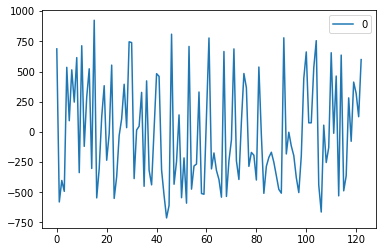

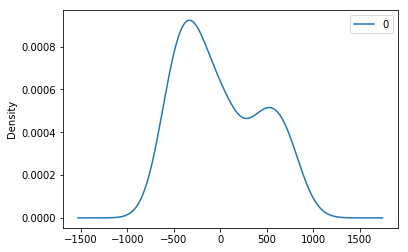

                0
count  123.000000
mean    -9.278663
std    435.587550
min   -712.674092
25%   -374.806923
50%   -119.825127
75%    388.386003
max    924.719850


In [27]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [28]:
predictions=model_fit.forecast(steps=test.size)[0]

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

Test RMSE: 501.635
Test R2: -0.026


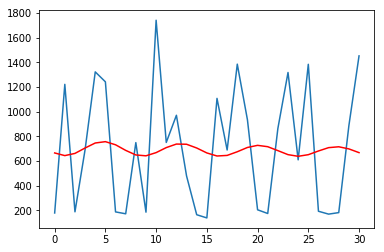

In [29]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [52]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

X = series.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]

In [60]:
arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                         start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, seasonal=True, m=30, 
                         error_action='warn', trace=True, suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 30); AIC=1770.475, BIC=1775.820, Fit time=0.157 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 30); AIC=1721.901, BIC=1732.592, Fit time=10.635 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 30); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 30); AIC=1746.272, BIC=1754.291, Fit time=0.333 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 30); AIC=1717.626, BIC=1730.991, Fit time=24.687 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 30); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 1, 30); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 30); AIC=1743.122, BIC=1753.814, Fit time=22.218 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 30); AIC=1713.826, BIC=1729.863, Fit time=36.456 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 30); AIC

In [ ]:
arima_model.summary()

In [ ]:
predictions = arima_model.predict(n_periods=len(test))

plt.plot(test)
plt.plot(predictions, color='red')
plt.title("Test data Vs. Predictions")
plt.show()

In [35]:
#### ROLLING FORECAST

X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Huge difference in results between rolling forecast vs. multi-step forecasting. This is why deploying forecasting algorithms to production is very different from deploying other ML models. It wouldn't be prudent to deploy a static model and score it, as the concept of model serving doesn’t make sense for time series forecasting. The only way around this is to retrain your model every time you get new data. Note that this is not the same as continuous learning, where an already trained model is updated as new data comes in. In some cases, it is beneficial to actually retraining a new model from scratch everytime you want to generate a new forecast.

In [ ]:
#additional grid-searching using R2 score

def r2_evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    r2 = r2_score(test, predictions)
    return r2

In [ ]:
def r2_evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = 0, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    r2 = r2_evaluate_arima_model(dataset, order)
                    if r2 > best_score:
                        best_score, best_cfg = r2, order
                    print('ARIMA%s R2=%.3f' % (order,r2))
                except:
                    continue
    print('Best ARIMA%s R2=%.3f' % (best_cfg, best_score))

In [55]:
# grid-search and evaluate parameters
import warnings
warnings.filterwarnings("ignore")

p_values = range(0, 4)
d_values = range(0, 1)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
r2_evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) R2=-3.050
ARIMA(0, 0, 1) R2=-1.947
ARIMA(0, 0, 2) R2=-0.853
ARIMA(0, 1, 0) R2=-0.391
ARIMA(0, 1, 1) R2=0.262
ARIMA(0, 2, 0) R2=-4.203
ARIMA(0, 2, 1) R2=-0.416
ARIMA(1, 0, 0) R2=-0.786
ARIMA(1, 1, 0) R2=0.450
ARIMA(1, 1, 1) R2=0.459
ARIMA(1, 2, 0) R2=-0.438
ARIMA(2, 0, 0) R2=0.207
ARIMA(2, 1, 0) R2=0.560
ARIMA(2, 1, 1) R2=0.400
ARIMA(2, 2, 0) R2=0.238
ARIMA(3, 1, 0) R2=0.459
ARIMA(3, 1, 1) R2=0.448
ARIMA(3, 2, 0) R2=0.188
ARIMA(4, 1, 0) R2=0.486
ARIMA(4, 1, 1) R2=0.475
ARIMA(4, 2, 0) R2=0.413
ARIMA(4, 2, 1) R2=0.637
ARIMA(5, 1, 0) R2=0.462
ARIMA(5, 2, 0) R2=0.482
Best ARIMA(4, 2, 1) R2=0.637
